In [ ]:
# Let's import the needed packages

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# 1. One-month prediction

In [48]:
# Get the data for a 1-month prediction, split and scale the data

X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline n°1 - LDA

### 1.1 First evaluation

In [40]:
# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred_lda)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 0.989
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.778
     AUC for TEST data: 0.883


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

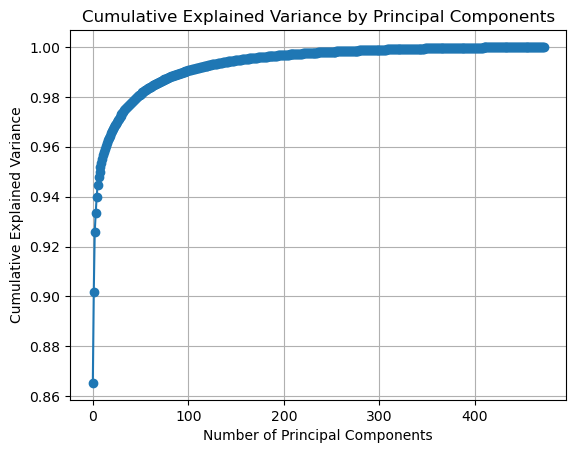

In [41]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [5]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred_lda = lda.predict(X_test)
    y_train_pred_lda = lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred_lda))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred_lda))


In [6]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Improvement of the test score: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 44
Train Score for the best p: 0.9331550802139037
Test Score for the best p: 0.93
Improvement of the test score: + 0.07


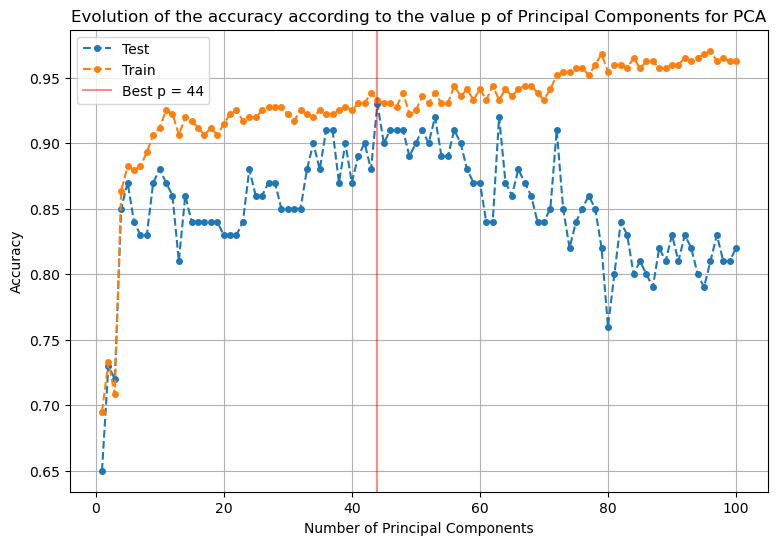

In [7]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.90
Test auc with the best p: 0.96


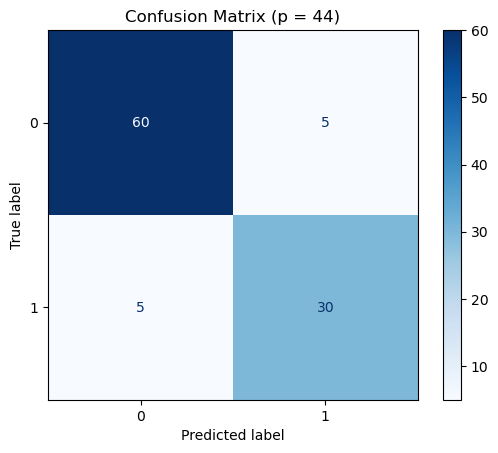

In [8]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_test_pred_lda = lda.predict(X_test)

# Print the scores
test_accuracy = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_lda_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_lda)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 2. Ridge and Lasso classifications

### 2.1 Ridge classification

In this part, we will use the Ridge algorithm to perform a regularization of our model, trying to prevent overfitting.

In [49]:
# Take our data without the PCA dimensionality reduction
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)
X_train, X_validation, y_train, y_validation = useful_functions.split_scale_data(X_train, y_train, RANDOM_SPLIT = False, train_size = 300, verbose = False)

In [50]:
# Define the classifier
ridge = RidgeClassifier(alpha=1.0) # Default hyperparameter

# Fit
ridge.fit(X_train, y_train)

# Predict
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {ridge.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {ridge.score(X_test, y_test):.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.760


c:\Users\natha\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=9.23523e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
c:\Users\natha\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=4.91438e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
c:\Users\natha\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=4.12313e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
c:\Users\natha\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=8.93293e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

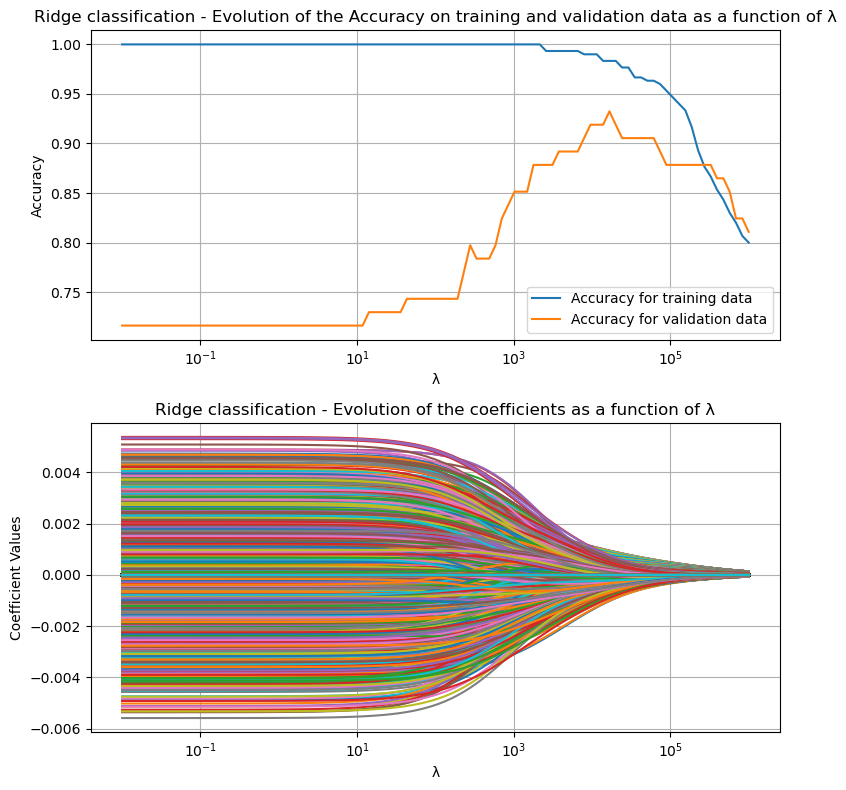

In [ ]:
# Prepare the lambda values
lambda_values = np.logspace(-2, 6, 100)

# Initialisation of the lists that will contain the accuracies and the coefficients
accuracy_train_list = []
accuracy_valid_list = []
coefficients = []

for i in range(len(lambda_values)):
    # Define the classifier
    ridge = RidgeClassifier(alpha=lambda_values[i])

    # Fit
    ridge.fit(X_train, y_train)
    
    # Computation of the accuracy for train and validation
    accuracy_train_ridge = ridge.score(X_train, y_train)
    accuracy_valid_ridge = ridge.score(X_validation, y_validation)

    
    # Add the values to the accuracy lists
    accuracy_train_list.append(accuracy_train_ridge)
    accuracy_valid_list.append(accuracy_valid_ridge)
    
    # Store the coefficients
    coefficients.append(ridge.coef_)
    
coefficients = np.array(coefficients)

# Plot the results
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.semilogx(lambda_values, accuracy_train_list, label="Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label="Accuracy for validation data")
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge classification - Evolution of the Accuracy on training and validation data as a function of λ')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge classification - Evolution of the coefficients as a function of λ')

plt.tight_layout() 

In [53]:
# Get the best score
best_index = np.argsort(-np.array(accuracy_valid_list))[0]
best_lambda_value = lambda_values[best_index]
best_valid_score_ridge = accuracy_valid_list[best_index]
best_train_score_ridge = accuracy_train_list[best_index]

# Print
print(f"Best lambda value after validation: {best_lambda_value:.1f}")
print(f"Accuracy for training: {best_train_score_ridge:.3f}")
print(f"Accuracy for validation: {best_valid_score_ridge:.3f}")

Best lambda value after validation: 16681.0
Accuracy for training: 0.983
Accuracy for validation: 0.932


Accuracy for test: 0.930


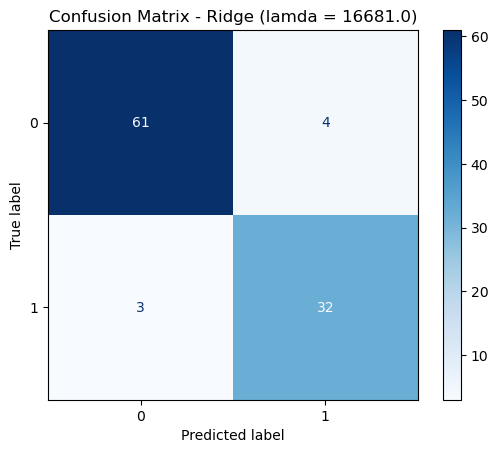

In [54]:
# Get the best Ridge model
# Define the regressor
ridge = RidgeClassifier(alpha=best_lambda_value)
# Fit
ridge.fit(X_train, y_train)
# Print the test result
print(f"Accuracy for test: {ridge.score(X_test, y_test):.3f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, ridge.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ridge.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Ridge (lamda = {best_lambda_value:.1f})")
plt.show()

Peut-être essayer la PCA avant de faire le Ridge.

### 2.2 Lasso classification using Logistic regression

In this part, we will use the Lasso algorithm to perform a regularization of our model, trying to prevent overfitting. As there is no "LassoClassifier" function, we will use the LogisticRegression function with penalty parameter set to "l1".

In [59]:
# Define the classifier
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0) # Default hyperparameter

# Fit
lasso.fit(X_train, y_train)

# Predict
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {lasso.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {lasso.score(X_test, y_test):.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.900


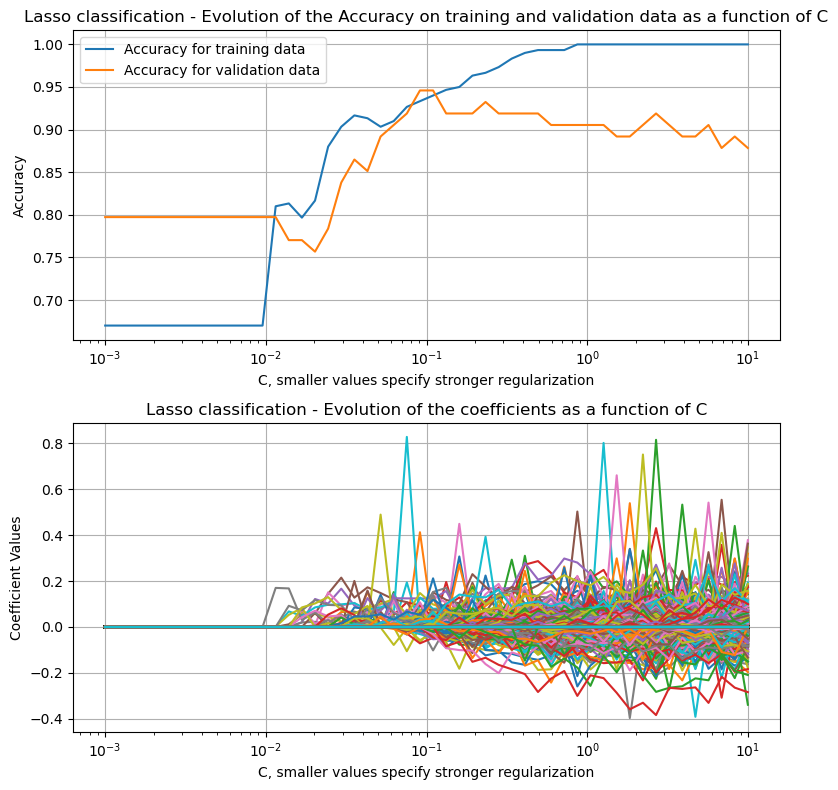

In [60]:
# Prepare the regularization parameter values
C_values = np.logspace(-3, 1, 50)

# Initialisation of the lists that will contain the accuracies and the coefficients
accuracy_train_list = []
accuracy_valid_list = []
coefficients = []

for i in range(len(C_values)):
    # Define the classifier
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=C_values[i])

    # Fit
    lasso.fit(X_train, y_train)

    # Predict
    y_train_pred = lasso.predict(X_train)
    y_valid_pred = lasso.predict(X_validation)
    
    # Computation of the accuracy for train and validation
    accuracy_train_lasso = lasso.score(X_train, y_train)
    accuracy_valid_lasso = lasso.score(X_validation, y_validation)

    
    # Add the values to the accuracy lists
    accuracy_train_list.append(accuracy_train_lasso)
    accuracy_valid_list.append(accuracy_valid_lasso)
    
    # Store the coefficients
    coefficients.append(lasso.coef_)
    
coefficients = np.array(coefficients)

# Plot the results
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_list, label="Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label="Accuracy for validation data")
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

# Get the best score
best_index = np.argsort(-np.array(accuracy_valid_list))[0]
best_C_value = C_values[best_index]
best_valid_score_lasso = accuracy_valid_list[best_index]
best_train_score_lasso = accuracy_train_list[best_index]

Best C value after validation: 0.09
Accuracy for training: 0.933
Accuracy for validation: 0.946
Accuracy for test: 0.870


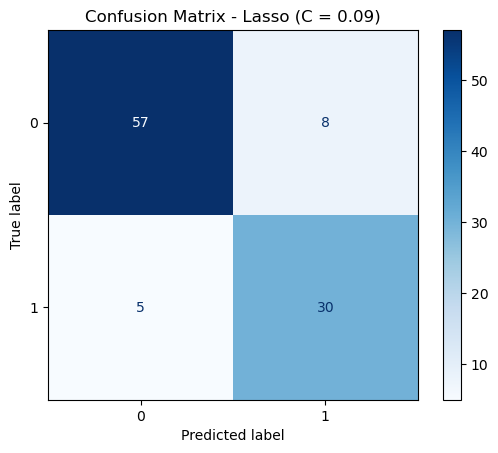

In [63]:
# Print
print(f"Best C value after validation: {best_C_value:.2f}")
print(f"Accuracy for training: {best_train_score_lasso:.3f}")
print(f"Accuracy for validation: {best_valid_score_lasso:.3f}")

# Get the best Lasso model
# Define the regressor
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=best_C_value)
# Fit
lasso.fit(X_train, y_train)
# Print the test result
print(f"Accuracy for test: {lasso.score(X_test, y_test):.3f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, lasso.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lasso.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Lasso (C = {best_C_value:.2f})")
plt.show()

## 3. Test Different Models

QDA - Accuracy: 0.65, AUC: 0.7116483516483516

---------------------
QDA cross val - Best Parameters: {'reg_param': 0.9}
QDA cross val - Tuned Accuracy: 0.83, Tuned AUC: 0.9525274725274724

---------------------
LogisticRegression - Accuracy: 0.89, AUC: 0.9674725274725275

---------------------
LogisticRegression cross val - Best Parameters: {'C': 1}
LogisticRegression cross val - Tuned Accuracy: 0.89, Tuned AUC: 0.9674725274725275

---------------------
RandomForestClassifier - Accuracy: 0.85, AUC: 0.947032967032967

---------------------
RandomForestClassifier cross val - Best Parameters: {'max_depth': None, 'n_estimators': 50}
RandomForestClassifier cross val - Tuned Accuracy: 0.9, Tuned AUC: 0.9410989010989012

---------------------
SVC - Accuracy: 0.86, AUC: 0.9358241758241759

---------------------
SVC cross val - Best Parameters: {'C': 1, 'kernel': 'linear'}
SVC cross val - Tuned Accuracy: 0.9, Tuned AUC: 0.9683516483516483

---------------------
MLPClassifier - Accuracy: 0.81, 

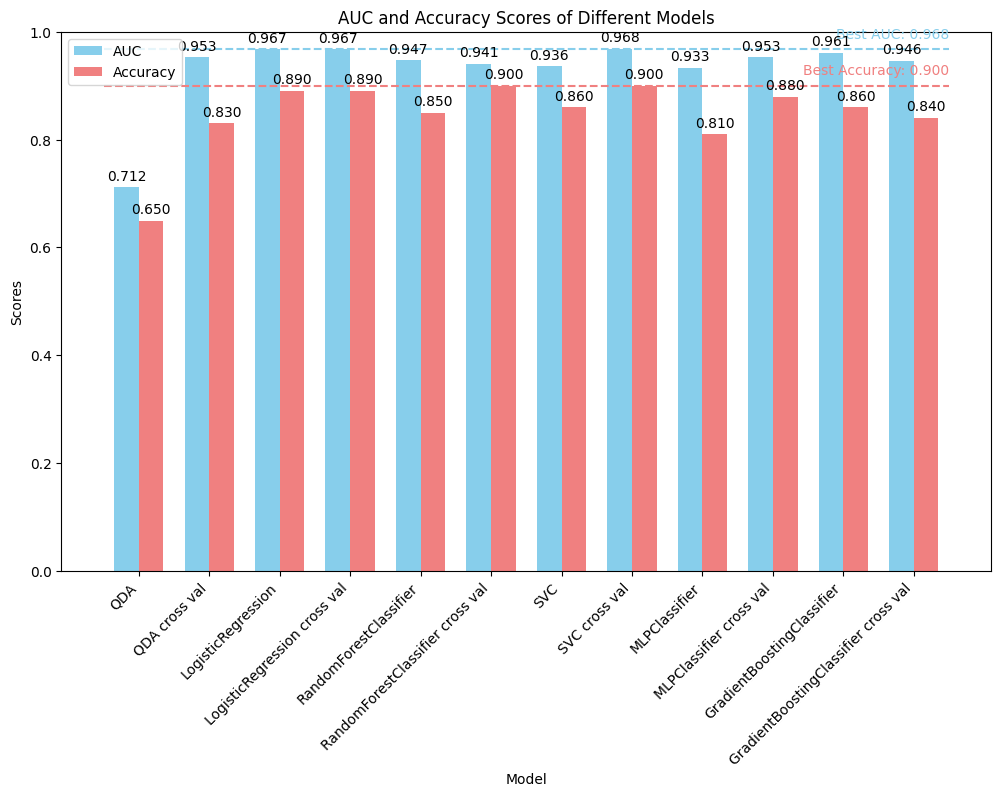

In [28]:
# The models that we are going to use 
models_names = ["QDA", "LogisticRegression", "RandomForestClassifier", "SVC", "MLPClassifier", "GradientBoostingClassifier"]
models = [QuadraticDiscriminantAnalysis(), LogisticRegression(), RandomForestClassifier(), SVC(probability = True), MLPClassifier(max_iter = 500), GradientBoostingClassifier()]

# The params of each model for cross validation
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
lr_params = {'C': [0.01, 0.1, 1, 10, 100]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
mlp_params = {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'alpha': [0.0001, 0.001, 0.01]}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [ qda_params, lr_params, rf_params, svc_params, mlp_params, gb_params]

#initialisations of the scores list and names (for the legend of the plot)
model_names_legend = []
auc_scores = []
accuracy_scores = []
best_model_name = None
best_model = None
best_accuracy = 0
best_auc = 0

for i in range (len(models)) :
    #first evaluate the basic model
    model, accuracy, auc = useful_functions.evaluate_model(models[i], models_names[i],  X_train, y_train, X_test, y_test)
    print('\n---------------------')
    model_names_legend.append(models_names[i])
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)

    if accuracy > best_accuracy or (accuracy == best_accuracy and auc > best_auc):
        best_model_name = models_names[i]
        best_model = model  
        best_accuracy = accuracy
        best_auc = auc

    #then tune the model 
    best_estimator_cv, best_params_cv, best_accuracy_cv, best_auc_cv = useful_functions.cross_validation(models[i], param_grids[i], X_train, y_train, X_test, y_test, models_names[i] + " cross val")
    print('\n---------------------')
    model_names_legend.append(models_names[i] + " cross val")
    auc_scores.append(best_auc_cv)
    accuracy_scores.append(best_accuracy_cv)

    if best_accuracy_cv > best_accuracy or (best_accuracy_cv == best_accuracy and best_auc_cv > best_auc):
        best_model_name = models_names[i] + " cross val"
        best_model = best_estimator_cv 
        best_accuracy = best_accuracy_cv
        best_auc = best_auc_cv

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")

#now me plot the histograms 
useful_functions.plot_score(model_names_legend, auc_scores, accuracy_scores)

If we consider accuracy as the reference score, SVC seems to be the best model. Let's perform PCA on it. 

## 4) Perform PCA on the best estimator

In [29]:
# Combine the best model with different values of

p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    model = best_model

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)

In [30]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 13
Train Score for the best p: 0.9224598930481284
Test Score for the best p: 0.93
Amélioration tu score de test: + 0.07


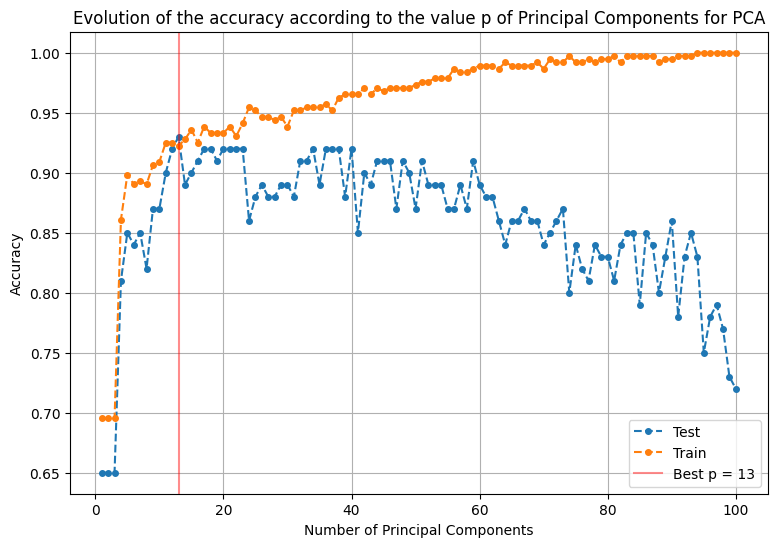

In [31]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.92
Test auc with the best p: 0.97


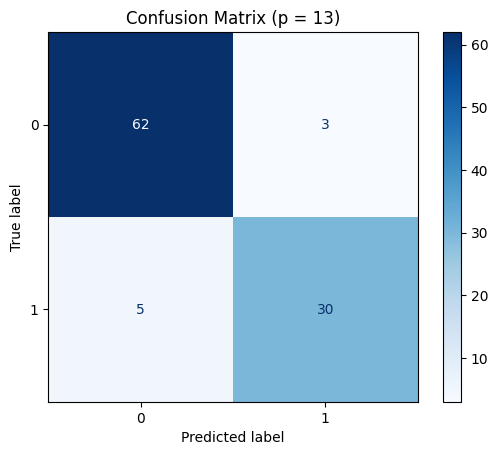

In [37]:
# PCA with the best value of p
# QUESTION: POURQUOI ON EST OBLIGE DE LE REFIT ?

PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)

# Print the scores
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc_score_test = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()